In [1]:
# Standard imports
import pandas as pd
import numpy as np

# Local module imports
import sys
import os
sys.path.append(os.path.abspath('../'))

from src.preprocessing.cleaning import handle_missing_values, remove_duplicates, convert_to_datetime
from src.preprocessing.feature_engineering import extract_time_features, convert_ip_to_int, merge_ip_country
from src.preprocessing.transform import encode_categorical, scale_features, handle_imbalance
from src.preprocessing.utils import load_csv, save_csv


In [ ]:
# Load raw data
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv', parse_dates=['purchase_time', 'signup_time'])
ip_map_df = load_csv('../data/raw/IpAddress_to_Country.csv')


In [7]:
print(fraud_df.head())
fraud_df.info()
fraud_df.describe()
print(fraud_df.isnull().sum())
fraud_df.dtypes


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          ----------

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [6]:
print(ip_map_df.dtypes)

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object


In [3]:
print(fraud_df['class'].value_counts())

class
0    136961
1     14151
Name: count, dtype: int64


In [4]:
# Handle missing values
fraud_df = handle_missing_values(fraud_df, strategy="drop")

# Remove duplicates
fraud_df = remove_duplicates(fraud_df)

In [5]:
# Time-based features
fraud_df = extract_time_features(fraud_df, 'purchase_time', 'signup_time')

# IP to integer
fraud_df = convert_ip_to_int(fraud_df)

# Convert IP bounds to integers in ip_map_df
ip_map_df['lower_bound_ip_address'] = ip_map_df['lower_bound_ip_address'].apply(int)
ip_map_df['upper_bound_ip_address'] = ip_map_df['upper_bound_ip_address'].apply(int)

# Merge geolocation
fraud_df = merge_ip_country(fraud_df, ip_map_df)

# Check new features
fraud_df[['hour_of_day', 'day_of_week', 'time_since_signup', 'country']].head()


,hour_of_day,day_of_week,time_since_signup,country
0,2,Saturday,1251.856111,Japan
1,1,Monday,4.984444,United States
2,18,Thursday,0.000278,United States
3,13,Monday,136.690278,Unknown
4,18,Wednesday,1211.516944,United States


In [ ]:
# Encoding categorical features
categorical_cols = ['source', 'browser', 'sex', 'country', 'day_of_week', 'hour_of_day']
fraud_df_encoded, encoder = encode_categorical(fraud_df, categorical_cols)

# Preview
fraud_df_encoded.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,time_since_signup,ip_int,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,7.327584e+08,0,1251.856111,732758368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,3.503114e+08,0,4.984444,350311387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,2.621474e+09,1,0.000278,2621473820,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,3.840542e+09,0,136.690278,3840542443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,4.155831e+08,0,1211.516944,415583117,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target
Xf = fraud_df_encoded.drop(columns=['class', 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time'])
yf = fraud_df_encoded['class']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    Xf, yf, test_size=0.2, stratify=yf, random_state=42
)

# Handle Class Imbalance (SMOTE)

Xf_train_bal, yf_train_bal = handle_imbalance(Xf_train, yf_train)

# Check new class distribution
pd.Series(yf_train_bal).value_counts()


class
0    109568
1    109568
Name: count, dtype: int64

In [5]:
# Scale Features

Xf_train_scaled, scaler = scale_features(Xf_train_bal, method='standard')
Xf_train_scaled_df = pd.DataFrame(Xf_train_scaled, columns=Xf.columns)
Xf_train_scaled_df.head()

Xf_test_scaled = scaler.transform(Xf_test)
Xf_test_scaled_df = pd.DataFrame(Xf_test_scaled, columns=Xf.columns)
Xf_test_scaled_df.head()

,purchase_value,age,time_since_signup,ip_int,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,0.403215,0.587403,1.806034,1.465873,1.287409,-0.546375,-0.830540,-0.878510,-0.460685,-0.572432,...,-0.219492,-0.221412,-0.218379,-0.227212,-0.219370,-0.217396,-0.207454,-0.211514,-0.215877,-0.21439
1,0.516297,0.467118,1.975332,0.812458,-0.835026,-0.546375,1.294586,-0.878510,-0.460685,-0.572432,...,-0.219492,-0.221412,-0.218379,-0.227212,-0.219370,-0.217396,-0.207454,-0.211514,-0.215877,-0.21439
2,-0.275278,0.346834,0.449622,-1.708909,1.287409,-0.546375,-0.830540,1.225511,-0.460685,-0.572432,...,-0.219492,-0.221412,-0.218379,-0.227212,4.926678,-0.217396,-0.207454,-0.211514,-0.215877,-0.21439
3,-0.671066,-0.976296,0.793819,1.149748,-0.835026,-0.546375,1.294586,-0.878510,2.335415,-0.572432,...,-0.219492,-0.221412,-0.218379,-0.227212,-0.219370,-0.217396,-0.207454,-0.211514,-0.215877,-0.21439
4,0.685920,1.068541,1.843233,-1.324788,-0.835026,1.986041,-0.830540,1.225511,-0.460685,-0.572432,...,-0.219492,-0.221412,-0.218379,-0.227212,-0.219370,-0.217396,-0.207454,-0.211514,-0.215877,-0.21439


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Define models to try
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

# Store results
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(Xf_train_scaled, yf_train_bal)
    
    # Predict
    y_pred = model.predict(Xf_test_scaled)
    y_proba = model.predict_proba(Xf_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate
    acc = accuracy_score(yf_test, y_pred)
    prec = precision_score(yf_test, y_pred, zero_division=0)
    rec = recall_score(yf_test, y_pred)
    f1 = f1_score(yf_test, y_pred)
    auc = roc_auc_score(yf_test, y_proba) if y_proba is not None else "N/A"
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n📊 Model Comparison:\n")
print(results_df.reset_index(drop=True))



Training Logistic Regression...

Training Random Forest...

Training XGBoost...


c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:12:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0        Random Forest  0.955564    0.99666  0.527208  0.689623  0.758412
1              XGBoost  0.952553    0.93625  0.529329  0.676298  0.769169
2  Logistic Regression  0.666314    0.17405  0.684452  0.277527  0.746324


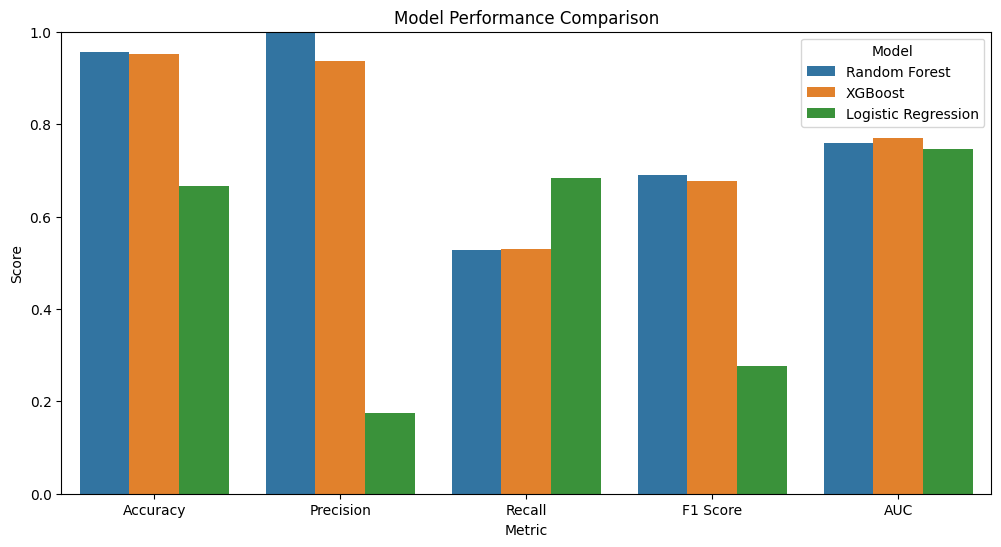

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is your model comparison DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.show()


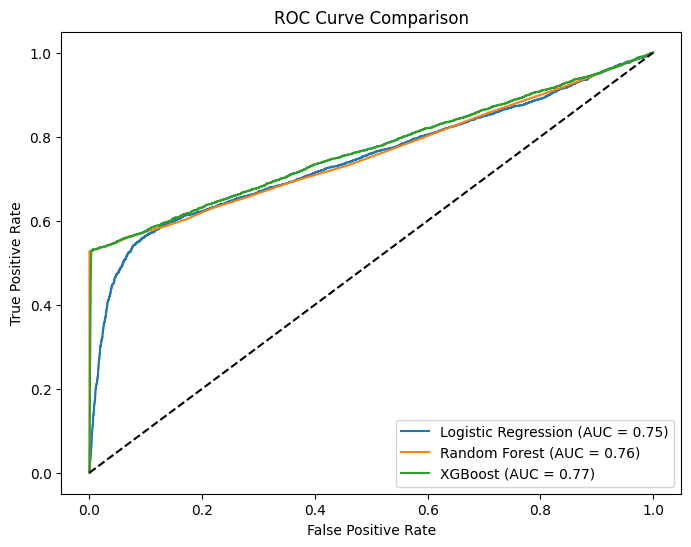

In [10]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(Xf_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(yf_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Processing for CreditCard data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the dataset
credit_df = pd.read_csv("../data/raw/creditcard.csv")


# Check class distribution
print(credit_df['Class'].value_counts())



Class
0    284315
1       492
Name: count, dtype: int64


In [28]:

Xc = credit_df.drop(columns=['Class'])  # Features
yc = credit_df['Class']                # Target

# Train-Test Split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)

# Handle Class Imbalance (SMOTE)

Xc_train_bal, yc_train_bal = handle_imbalance(Xc_train, yc_train)

# Scale Features
def scale_cr_features(X_train, X_test, method="standard"):
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, scaler

Xc_train_scaled, Xc_test_scaled, scaler = scale_cr_features(Xc_train_bal, Xc_test)

# Convert to DataFrames again for easier exploration
Xc_train_scaled_df = pd.DataFrame(Xc_train_scaled, columns=Xc.columns)
Xc_test_scaled_df = pd.DataFrame(Xc_test_scaled, columns=Xc.columns)

# Final Check
print("Final training set shape:", Xc_train_scaled_df.shape)
print("Final test set shape:", Xc_test_scaled_df.shape)
print("Resampled class distribution:", pd.Series(yc_train_bal).value_counts())



Final training set shape: (454902, 30)
Final test set shape: (56962, 30)
Resampled class distribution: Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
# Save the preprocessed data
import joblib

# For fraud data
joblib.dump(Xf_train_scaled, 'Xf_train_scaled.pkl')
joblib.dump(Xf_test_scaled, 'Xf_test_scaled.pkl')
joblib.dump(yf_train_bal, 'yf_train_bal.pkl')
joblib.dump(yf_test, 'yf_test.pkl')

# Do the same for creditcard data
joblib.dump(Xc_train_scaled, 'Xc_train_scaled.pkl')
joblib.dump(Xc_test_scaled, 'Xc_test_scaled.pkl')
joblib.dump(yc_train_bal, 'yc_train_bal.pkl')
joblib.dump(yc_test, 'yc_test.pkl')

# Save scalers if you used any
joblib.dump(scaler, 'scaler.pkl')
